In [2]:
import os, sys
import glob

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

import tensorflow as tf
import keras

In [3]:
print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")

Keras version: 3.8.0
TensorFlow version: 2.18.0


In [4]:
RANDOM_STATE = 42
IMAGE_SHAPE = (48, 48)
INPUT_SHAPE = (48, 48, 1)
EPOCHS = 300
BATCH_SIZE = 32
NUM_CLASSES = 7

In [5]:
os.getcwd()

'c:\\Users\\yostina\\Desktop\\imageproject'

In [6]:
os.listdir(r"C:\Users\yostina\Desktop\reacts")

['test', 'train']

In [7]:
os.listdir(r"C:\Users\yostina\Desktop\reacts\train")

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [8]:
train_path = r"C:\Users\yostina\Desktop\reacts\train"
test_path = r"C:\Users\yostina\Desktop\reacts\test"

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
train_datagen = ImageDataGenerator(
    rescale = 1./255, 
    rotation_range = 15, 
    width_shift_range = 10,
    height_shift_range = 10, 
    shear_range = 0.15,
    zoom_range = 0.15,
    horizontal_flip = True,
    validation_split = 0.2
)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [11]:
train_gen = train_datagen.flow_from_directory(
    train_path, 
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE, 
    color_mode = 'grayscale',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training' # train 0.8
)

val_gen = train_datagen.flow_from_directory(
    train_path, 
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE, 
    color_mode = 'grayscale',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation' # val 0.2
)
test_gen = test_datagen.flow_from_directory(
    test_path, 
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE, 
    color_mode = 'grayscale',
    class_mode = 'categorical',
    shuffle = False,
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [12]:
emotions = ['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']

Class [0 1 2 3 4 5 6]
Count [3196  349 3278 5772 3972 3864 2537]



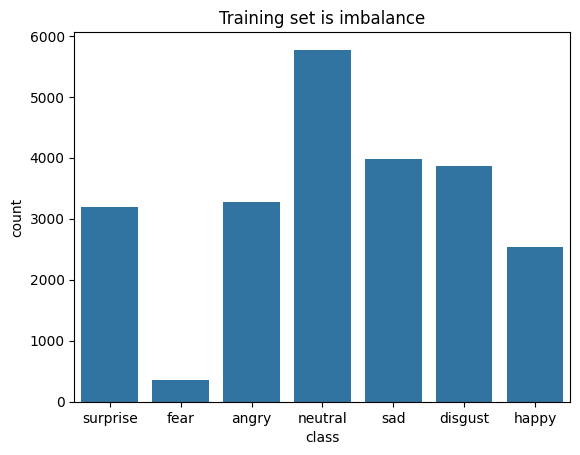

In [13]:
class_count = np.unique(train_gen.classes, return_counts = True)

print("Class", class_count[0])
print("Count", class_count[1])
print()

plt.figure()

sns.barplot(x = emotions, y = class_count[1])

plt.title("Training set is imbalance")
plt.xlabel('class')
plt.ylabel('count') 
plt.show()

In [14]:
from sklearn.utils.class_weight import compute_class_weight

In [15]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)

class_weights

array([1.02664044, 9.40155546, 1.00095877, 0.56845857, 0.82606819,
       0.84915705, 1.29331607])

In [16]:
d_class_weights = dict(enumerate(class_weights))
d_class_weights

{0: np.float64(1.0266404434114071),
 1: np.float64(9.401555464592715),
 2: np.float64(1.0009587727708533),
 3: np.float64(0.5684585684585685),
 4: np.float64(0.826068191627104),
 5: np.float64(0.8491570541259982),
 6: np.float64(1.2933160650937552)}

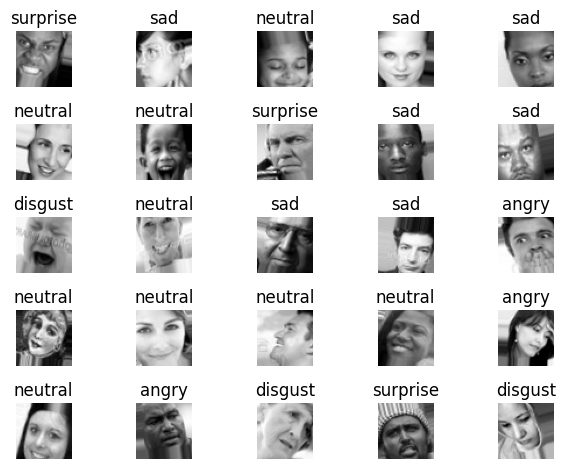

In [17]:
fig, axes = plt.subplots(ncols = 5, nrows = 5)
axes =axes.flatten()

for i in range(25):
    j = np.random.randint(train_gen.n)

    # take data 
    batch_images, batch_labels = train_gen[j // BATCH_SIZE]
    id_in_batch = j % BATCH_SIZE 
    image = batch_images[id_in_batch]
    label = batch_labels[id_in_batch].argmax()

    # show data
    axes[i].imshow(image, cmap = "gray")
    axes[i].set_title(emotions[label])
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [18]:
model = keras.models.Sequential([
    keras.Input(shape = INPUT_SHAPE),
    # 32
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same',),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # 64
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',),
    keras.layers.LayerNormalization(),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',),
     keras.layers.LayerNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # 128
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',),
    keras.layers.LayerNormalization(),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',),
    keras.layers.LayerNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # 256
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',),
    keras.layers.LayerNormalization(),
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same',),
    keras.layers.LayerNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # 512
    keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),

    # 1024
    keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same',),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same',),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    # Dense layers
    #Global Average Pooling layer is used instead of Flatten as it is more effiecient
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.Adam(learning_rate=0.0001, decay=1e-6), 
    metrics = ['accuracy'])

C:\Users\yostina\AppData\Roaming\Python\Python312\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 24, 24, 64)     │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 24, 24, 64)     │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 12, 12, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_3           │ (None, 12, 12, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_4           │ (None, 6, 6, 256)      │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,598,503 (78.58 MB)

 Trainable params: 20,588,647 (78.54 MB)

 Non-trainable params: 9,856 (38.50 KB)

In [20]:
es = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                   min_delta = 0,
                                   patience = 3, 
                                   verbose = 1,
                                   restore_best_weights = True)

# define modelcheckpointt callback
cp = keras.callbacks.ModelCheckpoint(filepath = "ferNet.keras",
                     save_best_only = True,
                     verbose = 1,
                     mode = 'min')

CALLBACKS  = [cp, es]

In [ ]:
H = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    class_weight = d_class_weights
)

C:\Users\yostina\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 598s 818ms/step - accuracy: 0.1462 - loss: 3.1138 - val_accuracy: 0.1533 - val_loss: 2.0931
Epoch 2/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 2597s 4s/step - accuracy: 0.1480 - loss: 2.7925 - val_accuracy: 0.1702 - val_loss: 1.9997
Epoch 3/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 419s 584ms/step - accuracy: 0.1519 - loss: 2.5479 - val_accuracy: 0.1580 - val_loss: 1.9971
Epoch 4/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 553s 771ms/step - accuracy: 0.1497 - loss: 2.3898 - val_accuracy: 0.1395 - val_loss: 2.1079
Epoch 5/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 497s 692ms/step - accuracy: 0.1524 - loss: 2.2775 - val_accuracy: 0.1641 - val_loss: 1.9846
Epoch 6/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 529s 736ms/step - accuracy: 0.1432 - loss: 2.2755 - val_accuracy: 0.1580 - val_loss: 1.9905
Epoch 7/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 469s 652ms/step - accuracy: 0.1374 - loss: 2.2091 - val_accuracy: 0.1441 - val_loss: 1.9787
Epoch 8/300
718/718 ━━━━━━━━━━━━━━━━━━━━ 646s 853ms/step - accuracy: 0.

In [ ]:
score = model.evaluate(test_gen, verbose=1)
print(f"Test loss: {score[0]:.4f}")
print(f"Test accuracy: {score[1]:.4f}")

In [ ]:
model.save(f'test_acc_{round(score[1],2)}.keras')

In [ ]:
pred_y = model.predict(test_gen)
pred_label = np.argmax(pred_y, axis=1)

true_label = test_gen.classes

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score

In [ ]:
cfs_mt = confusion_matrix(true_label, pred_label)

plt.figure()

sns.heatmap(cfs_mt, annot = True, fmt = 'd')

plt.show()

In [ ]:
print(classification_report(true_label, pred_label))

In [ ]:
f1_scores = f1_score(true_label, pred_label, average=None)

f1_data = pd.DataFrame({
    'Emotion': emotions,
    'F1-Score': f1_scores
})

In [ ]:
f1_macro = f1_score(true_label, pred_label, average='macro')
print(f"F1-score macro: {f1_macro}")

In [ ]:
f1_data

In [ ]:
plt.figure()

sns.barplot(data=f1_data, x='Emotion', y='F1-Score')

plt.title('F1-Scores per Emotion')
plt.xticks(rotation=45)
plt.ylim(0, 1)

# add data label
for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

In [ ]:
# show 25 random test image and model predictions of them
fig, axes = plt.subplots(ncols = 5, nrows = 5, figsize = (15, 15))
axes =axes.flatten()

for i in range(25):
    j = np.random.randint(test_gen.n)

    # take data 
    batch_images, batch_labels = test_gen[j // BATCH_SIZE]
    id_in_batch = j % BATCH_SIZE 
    image = batch_images[id_in_batch]
    label = batch_labels[id_in_batch].argmax()

    # show data
    axes[i].imshow(image, cmap = "gray")
    axes[i].set_title(f"True label: {emotions[label]}\nPredicted: {emotions[pred_label[j]]}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()